In [7]:
%load_ext autoreload
%autoreload 2

import os
import sys
import argparse
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import torch
from tifffile import imshow
import open3d as o3d
from tqdm import tqdm

In [6]:
from features import Features
from fpfh_features import FPFHFeatures, get_fpfh_features
# from feature_extractors.rgb_fpfh_features import RGBFPFHFeatures
from mvtec3d import mvtec3d_classes, get_data_loader

In [3]:
classes = mvtec3d_classes()

methodS = [
    "FPFH"
    #"RGB + FPFH"
]

In [4]:
method = methodS[0]
cls = classes[0] # FPFH only

In [5]:
print(f"\nRunning on class {cls}\n")

# Training
train_loader = get_data_loader("train", class_name=cls, img_size=224)

# Adding samples to memory bank
method = FPFHFeatures()
for sample, _ in tqdm(train_loader, desc=f"Extracting train features for class {cls}"):
    method.add_sample_to_mem_bank(sample)

print(f"\n\nRunning coreset for FPFH on class {cls}...")
method.run_coreset()


Running on class cable_gland



INFO - 2022-07-08 11:50:41,662 - helpers - Loading pretrained weights from url (https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/wide_resnet50_racm-8234f177.pth)
Extracting train features for class cable_gland: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]




Running coreset for FPFH on class cable_gland...
   Fitting random projections. Start dim = torch.Size([784, 33]).
   Error: could not project vectors. Please increase `eps`.


100%|██████████| 77/77 [00:00<00:00, 1306.30it/s]


In [107]:
data = train_loader.dataset[0][0][1]

In [104]:
x = data[0].reshape(-1)[::10]
y = data[1].reshape(-1)[::10]
z = data[2].reshape(-1)[::10]

In [105]:
ind = ~((x==0) & (y==0) & (z==0))
x = x[ind]
y = y[ind]
z = z[ind]

In [106]:
px.scatter_3d(x=x, y=y, z=z)

FPFH Extraction

In [60]:
fp_data = get_fpfh_features(data)


In [54]:
averager = torch.nn.AvgPool2d(3 ,stride=1)
resizer = torch.nn.AdaptiveAvgPool2d((28,28))
fp_data_averaged = averager(fp_data)
fp_data_avg_resized = resizer(fp_data_averaged)

In [57]:
output_data = fp_data_avg_resized.reshape(fp_data_avg_resized.shape[1],-1).T

In [59]:
output_data.shape

torch.Size([784, 33])

In [61]:
test_loader = get_data_loader("test", cls, img_size=224)

In [89]:
test = test_loader.dataset[0][1]
test = test.squeeze()

In [114]:
data3 = train_loader.dataset[0][0][2]

In [115]:
data3.shape

torch.Size([3, 224, 224])

In [118]:
data3[1].shape

torch.Size([224, 224])

In [116]:
data3[2]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [111]:
data2= test_loader.dataset[0][0][1]
x = data2[0].reshape(-1)[::20]
y = data2[1].reshape(-1)[::20]
z = data2[2].reshape(-1)[::20]

In [124]:
test_loader.dataset[0][0][0].shape

torch.Size([3, 224, 224])

WARNING - 2022-07-08 14:49:09,298 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


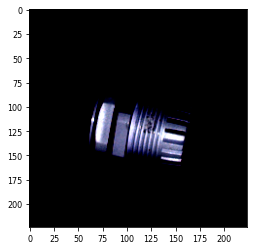

In [125]:
plt.imshow(test_loader.dataset[0][0][0].permute(2,1,0).numpy())

In [112]:
px.scatter_3d(x=x, y=y, z=z)

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7f63da4f7d90>)

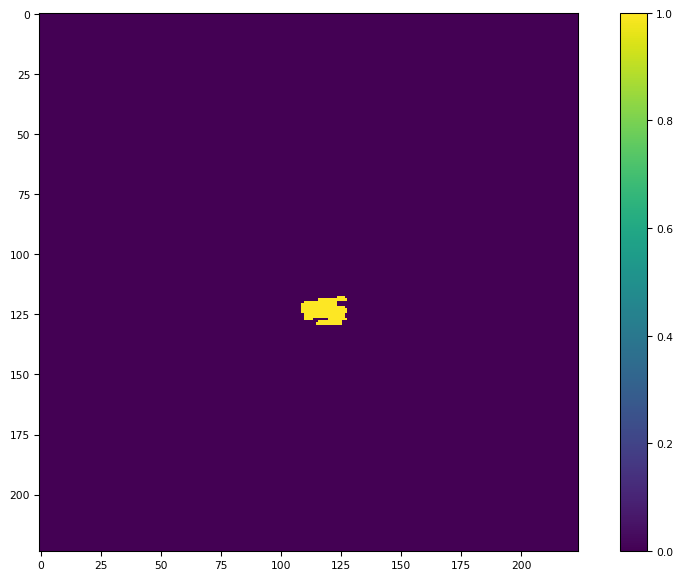

In [93]:
imshow(test.numpy())

In [26]:
image_rocaucs_df = pd.DataFrame(methodS, columns=['Method'])
pixel_rocaucs_df = pd.DataFrame(methodS, columns=['Method'])
au_pros_df = pd.DataFrame(methodS, columns=['Method'])

In [27]:
#Testing and Evaluation
image_rocaucs = dict()
pixel_rocaucs = dict()
au_pros = dict()
test_loader = get_data_loader("test", class_name=cls, img_size=224)
with torch.no_grad():
    for sample, mask, label in tqdm(test_loader, desc=f"Extracting test features for class {cls}"):
        method.predict(sample, mask, label)
method.calculate_metrics()
image_rocaucs["FPFH"] = round(method.image_rocauc, 3)
pixel_rocaucs["FPFH"] = round(method.pixel_rocauc, 3)
au_pros["FPFH"] = round(method.au_pro, 3)
print(f'Class: {cls}, FPFH Image ROCAUC: {method.image_rocauc:.3f}, FPFH Pixel ROCAUC: {method.pixel_rocauc:.3f}, FPFH AU-PRO: {method.au_pro:.3f}')

Extracting test features for class cable_gland: 100%|██████████| 108/108 [00:13<00:00,  8.03it/s]


Class: cable_gland, FPFH Image ROCAUC: 0.516, FPFH Pixel ROCAUC: 0.923, FPFH AU-PRO: 0.749


In [28]:
image_rocaucs_df['Mean'] = round(image_rocaucs_df.iloc[:, 1:].mean(axis=1),3)
pixel_rocaucs_df['Mean'] = round(pixel_rocaucs_df.iloc[:, 1:].mean(axis=1),3)
au_pros_df['Mean'] = round(au_pros_df.iloc[:, 1:].mean(axis=1),3)

#### Results with Unpreprocessed Dataset

ROCAUC Results on Image:
 - 'RGB iNet': 0.665,
 - 'Depth iNet': 0.504,
 - 'Raw': 0.779,
 - 'HoG': 0.534,
 - 'SIFT': 0.399,

ROCAUC Results on Pixels:
 - 'RGB iNet': 0.964,
 - 'Depth iNet': 0.788,
 - 'Raw': 0.283,
 - 'HoG': 0.851,
 - 'SIFT': 0.898

PRO Results:
 - 'RGB iNet': 0.886,
 - 'Depth iNet': 0.533,
 - 'Raw': 0.035,
 - 'HoG': 0.576,
 - 'SIFT': 0.726

#### Results with Preprocessed Dataset

ROCAUC Results on Image:

  * 'RGB iNet': 0.684,
  * 'Depth iNet': 0.515,
  * 'Raw': 0.429,
  * 'HoG': 0.482,
  * 'SIFT': 0.341,
  * 'FPFH': 0.558,
  * 'RGB + FPFH': 0.577

ROCAUC Results on Pixels:

  * 'RGB iNet': 0.965,
  * 'Depth iNet': 0.891,
  * 'Raw': 0.769,
  * 'HoG': 0.932,
  * 'SIFT': 0.943,
  * 'FPFH': 0.959,
  * 'RGB + FPFH': 0.98
  
PRO Results on Pixels:

  * 'RGB iNet': 0.886,
  * 'Depth iNet': 0.652,
  * 'Raw': 0.324,
  * 'HoG': 0.754,
  * 'SIFT': 0.802,
  * 'FPFH': 0.862,
  * 'RGB + FPFH': 0.93
